# Project work: Bias correction of climate model data

## Background
The CLEO research programme – CLimate change and Environmental Objectives – was set up in 2010 in response to a call from the Swedish Environmental Protection Agency for research with following general aims:
1. To analyse and quantify how changes in the climate, such as temperature, precipitation and run-off, affect our potential to achieve the Environmental Objectives that are influenced by long-range transport of air pollution.
2. To describe and analyse synergies and conflicts between national and international measures that aim to reduce emissions of greenhouse gases and other air pollutants in order to achieve the set objectives.
3. To improve our understanding of the underlying processes in order to develop reliable forecasts and scenarios for making progress towards the Environmental Objectives; improve input data for existing models; and enable better integration of models for the climate, air and ecosystems.

#### Scenarios and models
Two regional climate projections from SMHI were used in CLEO, based on ECHAM and HADLEY (two leading global climate models). Average daily temperature and precipitation from the projections were bias corrected using a [distribution based scaling method](https://www.researchgate.net/publication/240976573_Distribution_based_scaling_to_improve_usability_of_RCM_regional_climate_model_projections_for_hydrological_climate_change_impacts_studies) as part of the programme. Modelled data was corrected to SMHI stations arround Sweden.

The dynamic forest ecosystem model [ForSAFE](https://www.sciencedirect.com/science/article/pii/S037811270400725X) were one of the various models covering hydrology, bio-geochemical processes and leaching from forest land into surface water were used to study the effects of climate change and future emissions of air pollutants. This was a monthly version of ForSAFE and CLEO-project offered sufficient input data for running the modell, e.g. daily mean temperature.

The CLEO project has now ended but we continue using the climate projections in our research to study the effects of climate change and future emissions of air pollutioans on forest ecosystems across Sweden - Now with a new version of ForSAFE. One om may approvements was that the length of the time step was reduced from monthly to daily to better simulate the hydrology process, the microbial dynamics. This gives us output with higher resolution but at the same time requeres input with higher resolution,e.g. daily mean, max and min temperature.

We have optained bias corrected daily mean from the project but lack daily min and max, which could not be bias corrected in the project because the reference data only contained daily mean values for temperature(and precipitation). 

## Aim
The aim of this this jupyter notebook project is present a method for bias correcting daily minimum (maximum) temperature by deriving the correction from the correction of daily average temperature. No further analyse of the method will be done. We will bias correct GCM data using observation-based reference dataset from one station, the nearest one, for simplicity. 

The correction of the daily variability of min/max is described by calendar-month and grid-cell-specific transfer functions that are applied to the daily simulated data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Observation-based reference dataset
Meteorological observations for Ljungbyhed weather station, downloaded from:[SMHI](https://www.smhi.se/klimatdata/meteorologi/ladda-ner-meteorologiska-observationer#param=airTemperatureMinAndMaxOnceEveryDay,stations=all) 

In [2]:
#preferd method but not working 
#path = 'https://www.smhi.se/klimatdata/meteorologi/'
#url = path + 'ladda-ner-meteorologiska-observationer#param=airTemperatureMinAndMaxOnceEveryDay,stations=all,stationid=63050'
#tminmaxobs = pd.read_table(url, header=7, sep = ';')

first we take a look at the data

In [3]:
tminmaxobs = pd.read_csv('data/smhi-opendata_19_20_63050_20190103_115638.csv', header=7, sep = ';')
tminmaxobs.head()

,Från Datum Tid (UTC),Till Datum Tid (UTC),Representativt dygn,Lufttemperatur,Kvalitet,Lufttemperatur.1,Kvalitet.1,Unnamed: 7,Tidsutsnitt:
0,1950-12-31 18:00:01,1951-01-01 18:00:00,1951-01-01,-4.0,Y,-1.2,Y,NaN,Kvalitetskontrollerade historiska data (utom d...
1,1951-01-01 18:00:01,1951-01-02 18:00:00,1951-01-02,-2.0,Y,1.0,Y,NaN,Tidsperiod (fr.o.m.) = 1951-01-01 00:00:00 (UTC)
2,1951-01-02 18:00:01,1951-01-03 18:00:00,1951-01-03,0.2,Y,2.2,Y,NaN,Tidsperiod (t.o.m.) = 2001-07-16 23:59:59 (UTC)
3,1951-01-03 18:00:01,1951-01-04 18:00:00,1951-01-04,-1.0,Y,1.2,Y,NaN,Samplingstid = 24 timmar
4,1951-01-04 18:00:01,1951-01-05 18:00:00,1951-01-05,-0.7,Y,1.7,Y,NaN,NaN


We read the file with the desireable colums and use pd.DatetimeIndex to create a Pandas datetime object. 

In [4]:
tminmaxobs = pd.read_csv('data/smhi-opendata_19_20_63050_20190103_115638.csv', header=7, sep = ';',
                         usecols=['Representativt dygn', 'Lufttemperatur', 'Lufttemperatur.1'],
                         parse_dates=[0], infer_datetime_format=True)

tminmaxobs.rename(columns={'Lufttemperatur':'tmin', 'Lufttemperatur.1':'tmax'}, inplace=True)

temp = pd.DatetimeIndex(tminmaxobs['Representativt dygn'])
tminmaxobs['year'] = temp.year
tminmaxobs['month'] = temp.month
tminmaxobs['day'] = temp.day
del tminmaxobs['Representativt dygn']

tminmaxobs.set_index(['year','month','day'],inplace=True)
tminmaxobs.head()

tmin  tmax
year month day            
1951 1     1    -4.0  -1.2
           2    -2.0   1.0
           3     0.2   2.2
           4    -1.0   1.2
           5    -0.7   1.7

Tmean for the same station is in another file so we read the file, and load them in to a singel DataFrame.

In [5]:
tmeanobs = pd.read_csv('data/smhi-opendata_2_63050_20190105_224543.csv', header=6, sep = ';',
                       usecols=['Representativt dygn', 'Lufttemperatur'],
                       parse_dates=[0], infer_datetime_format=True)
tmeanobs.rename(columns={'Lufttemperatur':'tmean'}, inplace=True)

temp = pd.DatetimeIndex(tmeanobs['Representativt dygn'])
tmeanobs['year'] = temp.year
tmeanobs['month'] = temp.month
tmeanobs['day'] = temp.day
del tmeanobs['Representativt dygn']

tmeanobs.set_index(['year','month','day'],inplace=True)
tmeanobs.tail()


tmean
year month day       
2001 7     11    16.5
           12    15.8
           13    14.8
           14    16.1
           15    17.3

In [6]:
tobs = pd.concat([tmeanobs,tminmaxobs], axis=1)
tobs.head()

tmean  tmin  tmax
year month day                   
1949 1     1      2.8   NaN   NaN
           2      3.9   NaN   NaN
           3      3.2   NaN   NaN
           4      0.6   NaN   NaN
           5     -2.2   NaN   NaN

We create a new df for the reference period for the CLEO project: 1961–1990

In [7]:
observed_data_ref = tobs.loc[1961:1990]
observed_data_ref.tail()

tmean  tmin  tmax
year month day                   
1990 12    27     4.2   0.8   5.7
           28     3.3   1.9   4.2
           29     3.7   1.0   6.7
           30     4.1   2.8   5.5
           31     3.9   3.0   5.2

We now load the file VT_t2m_uncorrected.csv, containing uncorrected simulated data from the global climate model (GCM) ECHAM5_A1B3 for the gridcell were our site is located, Västra Torup (56.135 13.51). This extraction was done earlier in matlab and will not be covered in this example. It will be integrated in the same script in the final version.

In [8]:
#we first create a df and take a look at it
gcm_data_uncorr = pd.read_csv('data/VT_t2m_uncorrected.csv')
gcm_data_uncorr.head()

,date,tmin,tmean,tmax
0,1961-01-01,-5.736975,-4.720129,-2.544531
1,1961-01-02,-5.782294,-3.976965,-2.776709
2,1961-01-03,-5.785010,-4.405554,-3.167944
3,1961-01-04,-4.810523,-3.779822,-3.057898
4,1961-01-05,-3.315436,-2.240363,-1.639929


In [9]:
gcm_data_uncorr = pd.read_csv('data/VT_t2m_uncorrected.csv')

temp = pd.DatetimeIndex(gcm_data_uncorr['date'])
gcm_data_uncorr['year'] = temp.year
gcm_data_uncorr['month'] = temp.month
gcm_data_uncorr['day'] = temp.day
del gcm_data_uncorr['date']

gcm_data_uncorr.set_index(['year','month','day'],inplace=True)
gcm_data_uncorr.head()

tmin     tmean      tmax
year month day                              
1961 1     1   -5.736975 -4.720129 -2.544531
           2   -5.782294 -3.976965 -2.776709
           3   -5.785010 -4.405554 -3.167944
           4   -4.810523 -3.779822 -3.057898
           5   -3.315436 -2.240363 -1.639929

Then we load the bias-corrected daily mean temperature (modelled climate adjusted with SMHI observations) climate projection, allready extracted for our location. 

- Emission scenario:A1B
- GCM: ECHAM5r3
- RCM: RCA3,50x50km
- DBS version: DBS v2.0
- Reference data: PTHBV, 4x4 km    

In [10]:
gcm_data_bc = pd.read_csv('data/VT_t2m_mean_bc.csv')

temp = pd.DatetimeIndex(gcm_data_bc['date'])
gcm_data_bc['year'] = temp.year
gcm_data_bc['month'] = temp.month
gcm_data_bc['day'] = temp.day
del gcm_data_bc['date']

gcm_data_bc.set_index(['year','month','day'],inplace=True)
gcm_data_bc.head()

t2m_avg
year month day         
1961 1     1       -8.9
           2       -8.0
           3       -8.1
           4       -7.3
           5       -5.8

Then we concatenate the modelled data to one data frame and select the reference period.

In [11]:
gcm_data = pd.concat([gcm_data_uncorr,gcm_data_bc], axis=1)

gcm_data_ref = gcm_data.loc[1961:1990]
gcm_data_ref.head()

tmin     tmean      tmax  t2m_avg
year month day                                       
1961 1     1   -5.736975 -4.720129 -2.544531     -8.9
           2   -5.782294 -3.976965 -2.776709     -8.0
           3   -5.785010 -4.405554 -3.167944     -8.1
           4   -4.810523 -3.779822 -3.057898     -7.3
           5   -3.315436 -2.240363 -1.639929     -5.8

Daily minimum (maximum) temperature correction is derived from the correction of daily average temperature. We calculate the mean distance to the average temperature value over the reference period for both observations
and simulations:

In [12]:
# Put all data in the same DataFrame for convenience
all_data = pd.merge(observed_data_ref, gcm_data_ref, on=[ 'year', 'month', 'day'], suffixes=['_obs', '_mod'])
all_data.head()

tmean_obs  tmin_obs  tmax_obs  tmin_mod  tmean_mod  tmax_mod  \
year month day                                                                 
1961 1     1          0.6      -0.1       1.2 -5.736975  -4.720129 -2.544531   
           2          1.9       0.9       2.8 -5.782294  -3.976965 -2.776709   
           3          2.6       0.9       4.4 -5.785010  -4.405554 -3.167944   
           4          1.3      -0.9       3.6 -4.810523  -3.779822 -3.057898   
           5          1.1       0.1       2.8 -3.315436  -2.240363 -1.639929   

                t2m_avg  
year month day           
1961 1     1       -8.9  
           2       -8.0  
           3       -8.1  
           4       -7.3  
           5       -5.8

In [13]:
all_data[all_data.select_dtypes(exclude=['datetime']).columns] += 273.15

In [14]:
all_data.head()

tmean_obs  tmin_obs  tmax_obs    tmin_mod   tmean_mod  \
year month day                                                          
1961 1     1       273.75    273.05    274.35  267.413025  268.429870   
           2       275.05    274.05    275.95  267.367706  269.173035   
           3       275.75    274.05    277.55  267.364990  268.744446   
           4       274.45    272.25    276.75  268.339477  269.370178   
           5       274.25    273.25    275.95  269.834564  270.909637   

                  tmax_mod  t2m_avg  
year month day                       
1961 1     1    270.605469   264.25  
           2    270.373291   265.15  
           3    269.982056   265.05  
           4    270.092102   265.85  
           5    271.510071   267.35

The minimum and maximum daily temperatures (Tmin and Tmax
respectively) are here corrected for systematic bias. The algorithm from Hempel et al.2013 ensures
that in the historical period, the mean distance between the maximum
(minimum) daily temperature value and the daily average temperature (T) is
preserved. This is achieved by calculating the following factor over the
historical period(mod =modelled data, obs = obsereved data):

\begin{equation}
\mathrm{k} = \sum_{n=1}^{m=30} \frac{\left( T_{m,i j}^{obs}- T_{i j}^{obs} \right ) }{(T_{m,i j}^{mod}- T_{i j}^{mod}},
\end{equation}

and the resulting bias-corrected maximum (minimum) temperature is then
given by:

\begin{equation}
\mathrm{T_{m,i j}^{modBC}} = k * (T_{m,i j}^{mod}- T_{i j}^{mod}) + T_{m,i j}^{modBC}.
\end{equation}


In [15]:
# Create DataFrame for the daily correction factor to be applied to data later
daily_correction_factor = pd.DataFrame()

# Iterate over Months. Should perhaps also iterate over sites if more than one
for mday, frame in all_data.groupby(['month', 'day']):
    temp = pd.DataFrame()
    # eq. 25, Hempel et al., 2013
    # Min
    temp['min_range_mod'] = frame['tmin_mod'] - frame['tmean_mod']
    temp['min_range_obs'] = frame['tmin_obs'] - frame['tmean_obs']
    # Max
    temp['max_range_mod'] = frame['tmax_mod'] - frame['tmean_mod']
    temp['max_range_obs'] = frame['tmax_obs'] - frame['tmean_obs']
    
    k_min = temp['min_range_obs'].sum() / temp['min_range_mod'].sum()
    k_max = temp['max_range_obs'].sum() / temp['max_range_mod'].sum()
    
    new_data = {
        'month': mday[0],
        'day': mday[1],
        'k_min': k_min,
        'k_max': k_max
    }
    
    # Append the daily correction factor
    corr_df = pd.DataFrame([new_data], columns=new_data.keys())
    daily_correction_factor = daily_correction_factor.append(corr_df, ignore_index=True)
    del temp

# Merge all data into the same DataFrame for this we need to reset the DataFrame´s index
all_data.reset_index(inplace=True)
all_data = all_data.merge(daily_correction_factor, on=['month', 'day'])

# Apply the correction factor to the modelled data
# eq 26, Hempel et al., 2013
all_data['tmin_mod_corr'] = all_data['k_min'] * (all_data['tmin_mod'] - all_data['tmean_mod']) + all_data['t2m_avg']
all_data['tmax_mod_corr'] = all_data['k_max'] * (all_data['tmax_mod'] - all_data['tmean_mod']) + all_data['t2m_avg']

In [16]:
all_data.head()

,year,month,day,tmean_obs,tmin_obs,tmax_obs,tmin_mod,tmean_mod,tmax_mod,t2m_avg,k_min,k_max,tmin_mod_corr,tmax_mod_corr
0,1961,1,1,273.75,273.05,274.35,267.413025,268.429870,270.605469,264.25,2.582597,2.512124,261.623898,269.715372
1,1962,1,1,273.05,271.05,276.95,263.569886,267.418335,270.185486,262.95,2.582597,2.512124,253.011007,269.901426
2,1963,1,1,256.55,251.55,261.35,280.080231,280.475311,281.401490,280.35,2.582597,2.512124,279.329666,282.676675
3,1964,1,1,275.25,274.15,276.15,277.337158,279.032287,279.944702,278.35,2.582597,2.512124,273.972164,280.642099
4,1965,1,1,276.35,275.85,276.65,273.136658,276.080261,279.559967,274.05,2.582597,2.512124,266.447859,282.791452


then we plot the modelled data vs the bias corrected data

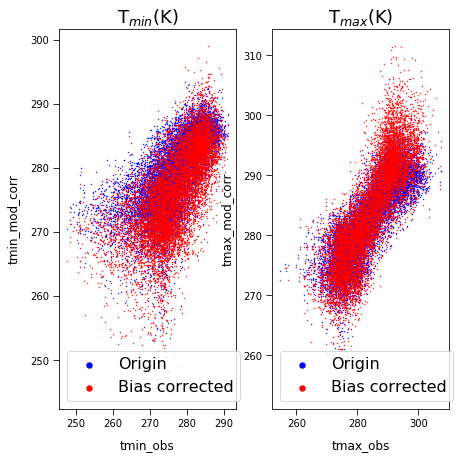

In [46]:
fig, ax = plt.subplots(1,2, figsize=(7, 7))

# Tmin
all_data.plot(kind='scatter', ax=ax[0],x='tmin_obs', y='tmin_mod', s=.2, c='b', label='Origin')
all_data.plot(kind='scatter', ax=ax[0],x='tmin_obs', y='tmin_mod_corr', s=.2, c='r', label='Bias corrected')
ax[0].set_title('T$_{min}$(K)', fontsize=18)
ax[0].legend(markerscale=12, fontsize=16)

# Tmax
all_data.plot(kind='scatter', ax=ax[1],x='tmax_obs', y='tmax_mod', s=.2, c='b', label='Origin')
all_data.plot(kind='scatter', ax=ax[1],x='tmax_obs', y='tmax_mod_corr', s=.2, c='r', label='Bias corrected')
ax[1].set_title('T$_{max}$(K)', fontsize=18)
ax[1].legend(markerscale=12, fontsize=16)
plt.savefig('figs/origin_vs_BC.png',dpi=300)
plt.show()

This was a first test of this method but apparently something is not correct. Further investigation will follow.

#### References

Hempel, S. et al. (2013) ‘A trend-preserving bias correction - the ISI-MIP approach’, Earth System Dynamics, 4(2), pp. 219–236. doi: 10.5194/esd-4-219-2013.